# NOTEBOOK NAME
Created by: Thomas Durand-Texte, 2023

# Import des packages et données
## import des packages

In [22]:
import os

import pandas as pd
import numpy as np
# import dask as dd
pd.set_option("display.max_columns", 200)
import datetime as dt
import scipy.stats as st

from sklearn import model_selection, metrics, preprocessing, linear_model


import matplotlib.pyplot as plt
import seaborn as sns

cm = 1./2.54

## Paramètres graphiques et fonctions utiles

In [23]:
import subprocess

white_font = True
def set_theme( white_font=True ):
    """ set_theme( white_font=True ) """
    if white_font: wht, grey, blck = '0.84' , '0.5', 'k'
    else: wht, grey, blck = 'k', '0.5', '0.84'
    rc = { 'figure.facecolor':(0.118,)*3,
            'axes.labelcolor':wht,
            'axes.edgecolor':wht,
            'axes.facecolor':(0,0,0,0),
            'text.color':'white',
            'text.usetex':False,
            'text.latex.preamble':r'\usepackage[cm]{sfmath} \usepackage{amsmath}' ,
            'font.family': 'sans-serif' ,
            'font.sans-serif': 'DejaVu Sans' ,
            'xtick.color':wht,
            'ytick.color':wht,
            "axes.grid" : True,
            "grid.color": (0.7,)*3,
            "grid.linewidth": 0.4,
            "grid.linestyle": (10,5),
            'legend.edgecolor':'0.2',
            'legend.facecolor':(0.2,0.2,0.2,0.6),
            # 'legend.framealpha':'0.6',
            'pdf.fonttype':42,
            'savefig.format':'pdf',
            'savefig.transparent':True,
            'figure.dpi':150, # for better agreemet figsize vs real size
        }

    sns.set_theme( 'notebook' , rc=rc )
    return


def make_folder( path_folder ):
    path_folder = path_folder.__str__()
    try:
        if os.path.isdir( path_folder ) : return
        os.makedirs(path_folder)
    except OSError:
        pass
    return

def concat_folders(*args, **kwargs):
    """ concat_folders(*args, **kwargs)
        concatenate folders in args (strings) """
    sPath = ''
    for arg in args:
        if arg == '..': sPath = sPath[:sPath[:-1].rfind(os.sep)+1]
        else: sPath += arg
        if sPath[-1] != os.sep: sPath += os.sep
    return sPath

class Path(object):
    """ Path( s_in='', s_lim=None)
        create a path to the string s_in (default is current path)
        and stops after s_lim """
    n_Path = 0
    def __init__(self, s_in='', s_lim=None):
        """docstring."""
        if s_in == '': s_in = os.getcwd()
        if not s_lim is None:
            if s_lim in s_in:
                s_in = s_in[ :s_in.index( s_lim ) + len(s_lim) ]
        self.sPath = concat_folders(s_in)
        self.N = Path.n_Path
        Path.n_Path += 1

    def __add__(self, other):
        """ Path + str : return str """
        if isinstance(other, str): return self.sPath + other

    def __truediv__(self, other):
        """ Path / str : return path concatenated"""
        if isinstance(other, str): return Path(concat_folders(self.sPath, other))

    def __invert__(self):
        """ ~Path : return str of the path """
        return self.sPath

    def __str__(self):
        """ __str__ return str of the path """
        return self.sPath
    # __str__ #

    def makedir( self ):
        return make_folder( self )


def gs_opt( filename ):
    """ otpimisation of a pdf file with gosthscript """
    filenameTmp = filename.replace('.pdf', '') + '_tmp.pdf'
    gs = ['gs',
            '-sDEVICE=pdfwrite',
            '-dEmbedAllFonts=true',
            '-dSubsetFonts=true',             # Create font subsets (default)
            '-dPDFSETTINGS=/prepress',        # Image resolution
            '-dDetectDuplicateImages=true',   # Embeds images used multiple times only once
            '-dCompressFonts=true',           # Compress fonts in the output (default)
            '-dNOPAUSE',                      # No pause after each image
            '-dQUIET',                        # Suppress output
            '-dBATCH',                        # Automatically exit
            '-sOutputFile='+filenameTmp,      # Save to temporary output
            filename]                         # Input file

    subprocess.run(gs)                                      # Create temporary file
    subprocess.run( 'rm -f ' + filename, shell=True)            # Delete input file
    subprocess.run( 'mv -f ' + filenameTmp + " " + filename, shell=True) # Rename temporary to input file

def savefig( fig, savename, **kwargs ):
    """ savefig( fig, savename, **kwargs )
        Saves a figure with kwargs (fig.savefig( savename, **kwargs) ).
        A check is done first to determine if a folder has to be created according to savename.
        Finally, if the file is saved as .pdf, gosthscript optimisation is performed. """
    if os.sep in savename: make_folder( savename[:savename.rindex(os.sep)] )
    fig.savefig( savename, **kwargs )
    savename += '.pdf'
    if os.path.isfile( savename ): gs_opt( savename )


def image_size_from_width_and_shape( width: float, shape: tuple, ymargin=0. ):
    """ return tuple (width, height) corresponding to image shape """
    return width, width*shape[0]/shape[1]+ymargin

def image_size_from_height_and_shape( height: float, shape: tuple, xmargin=0. ):
    """ return tuple (width, height) corresponding to image shape """
    return height*shape[1]/shape[0]+xmargin, height


set_theme()
del set_theme

## Chargement des données

Affichage de l'arborescence

In [24]:
x = np.arange(100)
y = 10 + 0.1 * x

lasso = linear_model.Lasso( alpha=1e-5, fit_intercept=True ).fit( x.reshape(-1,1), y )

10.000000594059404


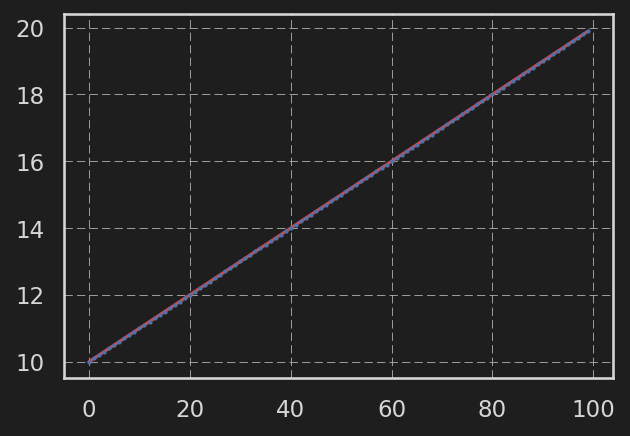

In [25]:
print( lasso.intercept_ )
fig, ax = plt.subplots( figsize=(12*cm,8*cm))
ax.plot( x[[0,-1]], lasso.predict( x[[0,-1]].reshape(-1,1) ), 'r' )
ax.plot( x, y, 'bo', markersize=1)

Chargement / compression des données

In [31]:
df = pd.DataFrame( {'a':[1,2,3], 'b':[4,5,6], 'c':[7,8,9]})
df

,a,b,c
0,1,4,7
1,2,5,8
2,3,6,9


In [32]:
print(df[:].values / df[:].sum(1).values)
df[:] = df[:].values / df[:].sum(1).values
df

[[0.08333333 0.26666667 0.38888889]
 [0.16666667 0.33333333 0.44444444]
 [0.25       0.4        0.5       ]]


,a,b,c
0,0.083333,0.266667,0.388889
1,0.166667,0.333333,0.444444
2,0.250000,0.400000,0.500000


In [30]:
df

,a,b,c
0,0.083333,0.266667,0.388889
1,0.166667,0.333333,0.444444
2,0.250000,0.400000,0.500000
